### 1. Imports

In [143]:
import os
import sys
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import itertools
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out UserWarning from specific module
warnings.filterwarnings("ignore", message="`layer.apply` is deprecated", category=UserWarning)


#tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (map, ndcg_at_k, precision_at_k, recall_at_k)
from recommenders.utils.constants import SEED as DEFAULT_SEED
#from recommenders.utils.notebook_utils import store_metadata

print("System version: {}".format(sys.version))
print("Pandas version: {}".format(pd.__version__))
print("Tensorflow version: {}".format(tf.__version__))

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint


System version: 3.9.18 (main, Sep 11 2023, 08:25:10) 
[Clang 14.0.6 ]
Pandas version: 1.5.3
Tensorflow version: 2.15.0


### 2. Setting Up Parameters

In [144]:
# top k items to recommend
TOP_K = 10

# Select  data size: 100k, 1m, 10m, or 20m
DATA_SIZE = 10000

# Model parameters
EPOCHS = 100 # ! Changed from 100 because it was taking forever
BATCH_SIZE = 256

SEED = DEFAULT_SEED  # Set None for non-deterministic results

### 3. Loading Dataframe


In [145]:
# * Load & Set Up Dataframe
original_dataframe = pd.read_csv('spotify_songs.csv')
CF_DF = original_dataframe

In [146]:
# Create Random Input Playlist of 10 Songs
input_samples = CF_DF.sample(n=10)
input_samples.to_csv('input.csv', index=False)

In [147]:
# Adding InputPlaylist to Dataframe
inputPlaylist = pd.read_csv('input.csv')
inputPlaylist['playlist_id'] = 'input_playlist'
inputPlaylist['playlist_name'] = 'input_playlist'

CF_DF = pd.concat([CF_DF, inputPlaylist], ignore_index=True)
df = CF_DF[['playlist_id', 'track_id']]

df.tail(10)

,playlist_id,track_id
32833,input_playlist,2DLfVnmabQqX3g3dnfvBe2
32834,input_playlist,0Q2wpj3vrY2oLiHamH2tDu
32835,input_playlist,53UXJ9NlgwfE8oOVFhinrS
32836,input_playlist,2RBnSQrhdtUnjqEj3upHTk
32837,input_playlist,4ngLDnC9X0ARJATJTXljdC
32838,input_playlist,3x2Vsy7q5bHgEPCbtPYKd8
32839,input_playlist,3wJTCCMHtuOdDg4fJzkd0i
32840,input_playlist,5wezdyzeY706PFC6pW0WvP
32841,input_playlist,3VNIHK4Dnxyf1EY2D1kolb
32842,input_playlist,6ZfTIN0gmZft7Ewe9gjOyR


In [148]:
# Create a DataFrame with all possible combinations of playlist_id and track_id
unique_playlists = df['playlist_id'].unique()
unique_tracks = df['track_id'].unique()

# Create a dataframe to store all combinations of playlist and track
all_combinations = pd.DataFrame([(playlist_id, track_id) for playlist_id in unique_playlists for track_id in unique_tracks],columns=['playlist_id', 'track_id'])
df = df.assign(rating=1)

# Merge with the original dataframe to check for existence
merged_df = all_combinations.merge(df, on=['playlist_id', 'track_id'], how='left')
#merged_df.drop_duplicates(subset=['playlist_id', 'track_id'], keep='first', inplace=True, ignore_index=True)

# Replace NaN values with 0 to represent absence of track in playlist
merged_df['rating'] = merged_df['rating'].fillna(0).astype(int)

# Select relevant columns
used_df = merged_df.loc[:, ['playlist_id', 'track_id', 'rating']]

# Filter out entries with playlist_id equal to 'input_user'
reg_df = used_df[used_df['playlist_id'] != 'input_playlist']
input_user_df = used_df[used_df['playlist_id'] == 'input_playlist']
input_user_df = input_user_df.sample(n=1000)
input_length = len(input_user_df)

# Step 2: Sample 10,000 - len(input_playlist) rows from reg_df
num_samples = 10000 - input_length
sampled_df = reg_df.sample(n=num_samples, replace=False)

# Step 3: Add the rows with input_playlist back to reg_df
concatenated_df = pd.concat([sampled_df, input_user_df], ignore_index=True)


# Factorizing 
concatenated_df['userID'], og_playlist_id = pd.factorize(concatenated_df['playlist_id'])
concatenated_df['itemID'], og_item_id  = pd.factorize(concatenated_df['track_id'])

UI_DF = concatenated_df[['userID', 'itemID', 'rating']]

#UI_DF.head()
print(len(UI_DF))
UI_DF.tail(10)

10000


,userID,itemID,rating
9990,471,7500,0
9991,471,8443,0
9992,471,8444,0
9993,471,8445,0
9994,471,8446,0
9995,471,8447,0
9996,471,404,0
9997,471,8448,0
9998,471,1453,0
9999,471,8449,0


In [149]:
#---USERS---#
# Get Playlist Numbers 
User_Num = concatenated_df[['userID', 'playlist_id']].copy()
User_Num.drop_duplicates(subset='userID', inplace=True)
print('User Reference Length: ', len(User_Num))

# Get Playlist Names 
User_Name = CF_DF[['playlist_id', 'playlist_name']].copy()
User_Name.drop_duplicates(subset='playlist_id', inplace=True)

# Merge Playlist Num & Names
User_Ref = User_Num.merge(User_Name, how = 'left')
print('User Reference Length After Merge: ', len(User_Ref))

#---ITEMS---#
# Get Item Numbers
Item_Num = concatenated_df[['itemID', 'track_id']].copy()
Item_Num.drop_duplicates(subset='itemID', inplace=True)
print('Item Reference Length: ',len(Item_Num))

# Get Item Name & Artist
Item_Name_Artist = CF_DF[['track_id', 'track_name', 'track_artist']].copy()
Item_Name_Artist.drop_duplicates(subset='track_id', inplace=True)

# Merge Item Num & Names/Artists
Item_Ref = Item_Num.merge(Item_Name_Artist, how = 'left')
print('Item Reference Length After Merge: ',len(Item_Ref))


User Reference Length:  472
User Reference Length After Merge:  472
Item Reference Length:  8450
Item Reference Length After Merge:  8450


### 4. Including Content Features - Potential Solution to Cold-Start Problem

In [150]:
#UI_DF = CF_DF.loc[0:10000]

# UserVector --> 'playlist_genre', 'playlist_subgenre', 
# ItemVector --> 'danceability', 'energy', 'key', 'loudness', 'valence', 'speechiness'

# Categoricals; Everything else is mostly between 0-1 so we're leaving them
#UI_DF['playlist_genre_fact'] = pd.factorize(UI_DF['playlist_genre'])[0] # 6 UV
#UI_DF['playlist_subgenre_fact'] = pd.factorize(UI_DF['playlist_subgenre'])[0] # 24 UV
#UI_DF['key_fact'] = pd.factorize(UI_DF['key'])[0] # 11 UV 


# UserVector
#UserVector = []
#ItemVector = []

#UserVector = [
    #[row['userID'], row['playlist_genre_fact'], row['playlist_subgenre_fact']]
    #for index, row in UI_DF.iterrows()
#]

#ItemVector = [
    #[row['itemID'], row['danceability'], row['energy'], row['key_fact'], row['loudness'], row['valence'], row['speechiness']]
    #for index, row in UI_DF.iterrows()
#]

#UI_DF['UserVector'] = UserVector
#UI_DF['ItemVector'] = ItemVector

#print(UI_DF['UserVector'])
#print(UI_DF['ItemVector'])

#UI_DF = UI_DF[['userID', 'itemID', 'playlist_genre_fact', 'playlist_subgenre_fact', 'danceability', 'energy', 'key_fact', 'loudness', 'valence', 'speechiness']]

#CUI_DF = UI_DF[['UserVector', 'ItemVector', 'rating']]
#CUI_DF.rename(columns={"UserVector": "userID", "ItemVector": "itemID", "rating": "rating"}, inplace = True)
#print(CUI_DF.head())

### 4. Training & Testing Split

In [151]:
#train, test = python_chrono_split(CF_DF, 0.75)
train, test = train_test_split(UI_DF, test_size=0.25, random_state=SEED)

In [152]:
test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]

In [153]:
leave_one_out_test = test.groupby("userID").last().reset_index()

In [154]:
train_file = "./splits/train.csv"
test_file = "./splits/test.csv"
leave_one_out_test_file = "./splits/leave_one_out_test.csv"
train = train.sort_values(by='userID')
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

In [155]:
leave_one_out_test.to_csv(leave_one_out_test_file, index=False)

### 5. NCF Dataset 

In [156]:
data = NCFDataset(train_file=train_file, test_file=leave_one_out_test_file, seed=SEED, overwrite_test_file_full=True)

INFO:recommenders.models.ncf.dataset:Indexing ./splits/train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./splits/leave_one_out_test.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file ./splits/leave_one_out_test_full.csv ...
100%|██████████| 321/321 [00:01<00:00, 254.23it/s]
INFO:recommenders.models.ncf.dataset:Indexing ./splits/leave_one_out_test_full.csv ...


### 6. Train NCF 

In [167]:
epoch_results = []
input_recs = []

epochs = [0, 10, 100, 200, 400, 500, 600]
for epochNum in epochs:
    
    print(f'################################# Epochs: {epochNum} ##############################################')

    epoch_result_row = []

    # add epoch number
    epoch_result_row.append(epochNum)

    print('---TRAIN---')
    model = NCF(
            n_users=data.n_users, 
            n_items=data.n_items,
            model_type="NeuMF",
            n_factors=4,
            layer_sizes=[16,8,4],
            n_epochs=epochNum,
            batch_size=BATCH_SIZE,
            learning_rate=1e-3,
            verbose=10,
            seed=SEED
        )

    with Timer() as train_time:
            model.fit(data)
            
    print("Took {} seconds for training.".format(train_time.interval))

    print(' ')

    print(' ')

    print('--- PREDICTIONS ---')

    predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
            for (_, row) in test.iterrows()]

    predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])

    # Group predictions by userID and rank remaining items based on predicted scores
    top_k_recs = predictions.groupby('userID').apply(lambda x: x.nlargest(TOP_K, 'prediction')).reset_index(drop=True)

    print('--- PREDICTIONS FOR INPUT USER ---')
    input_user_id = (len(User_Ref)) - 1 
    top_k_user = top_k_recs[(top_k_recs['userID'] == input_user_id)]

    row = User_Ref.loc[(User_Ref['userID'] == input_user_id)]

    item_list = top_k_user['itemID'].values

    input_rec_row = []
    input_rec_row.append(epochNum)
    
    i = 1
    print('Top 10 Recommendations For You:\n')
    for item in item_list:
        rec_info = []
        row = Item_Ref.loc[(Item_Ref['itemID'] == item)]

        name = row['track_name'].values[0]
        artist = row['track_artist'].values[0]
        
        rec_info.append(name)
        rec_info.append(artist)
        input_rec_row.append(rec_info)

        print(f"{i}.'{name}' - {artist}")
        i += 1
    
    input_recs.append(input_rec_row)

    print(' ')

    print('--- GENERIC EVALUATION ---')
    with Timer() as test_time:
        users, items, preds = [], [], []
        item = list(train.itemID.unique())
        for user in train.userID.unique():
            user = [user] * len(item) 
            users.extend(user)
            items.extend(item)
            preds.extend(list(model.predict(user, item, is_list=True)))

        all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

        merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
        all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

    print("Took {} seconds for prediction.".format(test_time.interval))

    eval_map = map(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

    print("MAP:\t%f" % eval_map,
        "NDCG:\t%f" % eval_ndcg,
        "Precision@K:\t%f" % eval_precision,
        "Recall@K:\t%f" % eval_recall, sep='\n')

    epoch_result_row.append(eval_map)
    epoch_result_row.append(eval_ndcg)
    epoch_result_row.append(eval_precision)
    epoch_result_row.append(eval_recall)

    print(' ')

    print('--- LEAVE-ONE-OUT EVALUATION ---')
    k = TOP_K

    ndcgs = []
    hit_ratio = []

    for b in data.test_loader():
        user_input, item_input, labels = b
        output = model.predict(user_input, item_input, is_list=True)

        output = np.squeeze(output)
        rank = sum(output >= output[0])
        if rank <= k:
            ndcgs.append(1 / np.log(rank + 1))
            hit_ratio.append(1)
        else:
            ndcgs.append(0)
            hit_ratio.append(0)

    eval_ndcg = np.mean(ndcgs)
    eval_hr = np.mean(hit_ratio)

    print("HR:\t%f" % eval_hr)
    print("NDCG:\t%f" % eval_ndcg)

    epoch_result_row.append(eval_ndcg)
    epoch_result_row.append(eval_hr)

    print(' ')
      
    epoch_results.append(epoch_result_row)

    print(' ')
    print(' ')


################################# Epochs: 0 ##############################################
---TRAIN---
Took 4.350000017439015e-05 seconds for training.
 
 
--- PREDICTIONS ---
--- PREDICTIONS FOR INPUT USER ---
Top 10 Recommendations For You:

1.'The One' - Habstrakt
2.'The Rain' - Oran Juice Jones
3.'3 A.M.' - Jesse & Joy
4.'Fly' - Prznt
5.'Your Light' - Scorpions
6.'The Air Near My Fingers' - The White Stripes
7.'Dry Ink' - Travel With The Sun
8.'Fin août - Yuksek remix' - Tim Dup
9.'Foreign Fields' - Kacy Hill
10.'Stress mit Grund (feat. Bushido & Haftbefehl)' - Shindy
 
--- GENERIC EVALUATION ---
Took 17.122629125000458 seconds for prediction.
MAP:	0.000346
NDCG:	0.000731
Precision@K:	0.000312
Recall@K:	0.001038
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.093458
NDCG:	0.062515
 
 
 
################################# Epochs: 10 ##############################################
---TRAIN---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.09s]: train_loss = 0.001049 


Took 12.920903375001217 seconds for training.
 
 
--- PREDICTIONS ---
--- PREDICTIONS FOR INPUT USER ---
Top 10 Recommendations For You:

1.'Fin août - Yuksek remix' - Tim Dup
2.'Turn Me On' - Kevin Lyttle
3.'It's Going Down' - South Circle
4.'Darte' - Alex Rose
5.'Still Crazy After All These Years' - Paul Simon
6.'Fly' - Prznt
7.'So Far Away' - Staind
8.'The Air Near My Fingers' - The White Stripes
9.'Walking (feat. Swae Lee & Major Lazer)' - 88rising
10.'Have You Ever Seen The Rain' - Creedence Clearwater Revival
 
--- GENERIC EVALUATION ---
Took 16.434865625000384 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.105919
NDCG:	0.062749
 
 
 
################################# Epochs: 100 ##############################################
---TRAIN---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.69s]: train_loss = 0.001082 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.27s]: train_loss = 0.000358 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.14s]: train_loss = 0.000202 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [2.29s]: train_loss = 0.000080 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [1.43s]: train_loss = 0.000111 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [1.89s]: train_loss = 0.000063 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.76s]: train_loss = 0.000020 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.91s]: train_loss = 0.000175 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.74s]: train_loss = 0.000162 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.69s]: train_loss = 0.000116 


Took 162.59254679200058 seconds for training.
 
 
--- PREDICTIONS ---
--- PREDICTIONS FOR INPUT USER ---
Top 10 Recommendations For You:

1.'Pictures [Tonite Only Remix]' - Sneaky Sound System
2.'All Right Now' - Free
3.'XO' - John Mayer
4.'Just Got Paid' - ZZ Top
5.'So Far Away' - Staind
6.'MIDDLE CHILD' - J. Cole
7.'The Truth Ain't What It Used To Be' - Wayward Sons
8.'Muppa - Reece Low Remix' - Contiez
9.'Stress mit Grund (feat. Bushido & Haftbefehl)' - Shindy
10.'The Groovy Cat' - PAWSA
 
--- GENERIC EVALUATION ---
Took 15.9909821250003 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.090343
NDCG:	0.055946
 
 
 
################################# Epochs: 200 ##############################################
---TRAIN---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.35s]: train_loss = 0.001069 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.28s]: train_loss = 0.000438 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.41s]: train_loss = 0.000198 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.16s]: train_loss = 0.000185 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [1.10s]: train_loss = 0.000133 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [1.02s]: train_loss = 0.000077 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.05s]: train_loss = 0.000070 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.21s]: train_loss = 0.000020 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.83s]: train_loss = 0.000091 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.48s]: train_loss = 0.000029 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [1.29s]: train_loss = 0.000034 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [1.37s]: 

Took 286.3837641250011 seconds for training.
 
 
--- PREDICTIONS ---
--- PREDICTIONS FOR INPUT USER ---
Top 10 Recommendations For You:

1.'Hardwired' - Metallica
2.'Your Light' - Scorpions
3.'Khatarnaak' - Gippy Grewal
4.'Stress mit Grund (feat. Bushido & Haftbefehl)' - Shindy
5.'Pictures [Tonite Only Remix]' - Sneaky Sound System
6.'Atrévete-Te-Te' - Calle 13
7.'3 A.M.' - Jesse & Joy
8.'It's Going Down' - South Circle
9.'Dust' - Van Hunt
10.'Flame - Kaskade Remix' - Tinashe
 
--- GENERIC EVALUATION ---
Took 16.022964291998505 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.121495
NDCG:	0.078141
 
 
 
################################# Epochs: 400 ##############################################
---TRAIN---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [2.22s]: train_loss = 0.001086 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [2.90s]: train_loss = 0.000357 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [2.40s]: train_loss = 0.000274 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.29s]: train_loss = 0.000081 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [2.85s]: train_loss = 0.000091 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [1.94s]: train_loss = 0.000110 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.59s]: train_loss = 0.000016 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.33s]: train_loss = 0.000011 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.53s]: train_loss = 0.000125 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.83s]: train_loss = 0.000065 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [2.57s]: train_loss = 0.000009 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [1.70s]: 

Took 720.9871090829984 seconds for training.
 
 
--- PREDICTIONS ---
--- PREDICTIONS FOR INPUT USER ---
Top 10 Recommendations For You:

1.'Hardwired' - Metallica
2.'The One' - Habstrakt
3.'Darte' - Alex Rose
4.'Clouds' - SamuW
5.'Khatarnaak' - Gippy Grewal
6.'Pintados' - Jenil
7.'Hold Back The River' - James Bay
8.'It's Going Down' - South Circle
9.'The Truth Ain't What It Used To Be' - Wayward Sons
10.'The Rain' - Oran Juice Jones
 
--- GENERIC EVALUATION ---
Took 21.83304337500158 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.009346
NDCG:	0.008169
 
 
 
################################# Epochs: 500 ##############################################
---TRAIN---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.23s]: train_loss = 0.001014 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.35s]: train_loss = 0.000365 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [2.16s]: train_loss = 0.000195 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.62s]: train_loss = 0.000108 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [1.57s]: train_loss = 0.000121 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [1.62s]: train_loss = 0.000058 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.29s]: train_loss = 0.000153 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.73s]: train_loss = 0.000057 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [2.05s]: train_loss = 0.000119 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.50s]: train_loss = 0.000022 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [2.05s]: train_loss = 0.000006 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [1.08s]: 

Took 536.6155667919993 seconds for training.
 
 
--- PREDICTIONS ---
--- PREDICTIONS FOR INPUT USER ---
Top 10 Recommendations For You:

1.'Hardwired' - Metallica
2.'The One' - Habstrakt
3.'Darte' - Alex Rose
4.'Clouds' - SamuW
5.'Khatarnaak' - Gippy Grewal
6.'Pintados' - Jenil
7.'Hold Back The River' - James Bay
8.'It's Going Down' - South Circle
9.'The Truth Ain't What It Used To Be' - Wayward Sons
10.'The Rain' - Oran Juice Jones
 
--- GENERIC EVALUATION ---
Took 14.774955999997474 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
 
--- LEAVE-ONE-OUT EVALUATION ---
HR:	0.006231
NDCG:	0.007330
 
 
 
################################# Epochs: 600 ##############################################
---TRAIN---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.72s]: train_loss = 0.001053 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.11s]: train_loss = 0.000378 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.42s]: train_loss = 0.000151 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.22s]: train_loss = 0.000066 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [1.12s]: train_loss = 0.000108 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [1.21s]: train_loss = 0.000129 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.97s]: train_loss = 0.000112 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.91s]: train_loss = 0.000075 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.25s]: train_loss = 0.000103 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.51s]: train_loss = 0.000027 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [2.02s]: train_loss = 0.000054 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [1.40s]: 

InvalidArgumentError: Graph execution error:

Detected at node 'optimizer/Adam/update_embedding/embedding_mlp_P/mul_2' defined at (most recent call last):
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/runpy.py", line 87, in _run_code
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/asyncio/events.py", line 80, in _run
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
    File "/var/folders/y5/gm5w6cr53lq9bx_hyjyfb7nr0000gn/T/ipykernel_34352/1529189136.py", line 15, in <module>
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/recommenders/models/ncf/ncf_singlenode.py", line 83, in __init__
    File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/recommenders/models/ncf/ncf_singlenode.py", line 269, in _create_model
Node: 'optimizer/Adam/update_embedding/embedding_mlp_P/mul_2'
Incompatible shapes: [0] vs. [472,8]
	 [[{{node optimizer/Adam/update_embedding/embedding_mlp_P/mul_2}}]]

Original stack trace for 'optimizer/Adam/update_embedding/embedding_mlp_P/mul_2':
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/runpy.py", line 197, in _run_module_as_main
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/runpy.py", line 87, in _run_code
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/asyncio/events.py", line 80, in _run
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in execute_request
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 446, in do_execute
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code
  File "/var/folders/y5/gm5w6cr53lq9bx_hyjyfb7nr0000gn/T/ipykernel_34352/1529189136.py", line 15, in <module>
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/recommenders/models/ncf/ncf_singlenode.py", line 83, in __init__
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/recommenders/models/ncf/ncf_singlenode.py", line 269, in _create_model
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/training/optimizer.py", line 486, in minimize
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/training/optimizer.py", line 725, in apply_gradients
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/training/optimizer.py", line 170, in update_op
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/training/optimizer.py", line 1087, in _resource_apply_sparse_duplicate_indices
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/training/adam.py", line 290, in _resource_apply_sparse
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/training/adam.py", line 259, in _apply_sparse_shared
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/ops/variables.py", line 1013, in _run_op
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 1478, in binary_op_wrapper
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 1881, in _mul_dispatch
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/ops/weak_tensor_ops.py", line 142, in wrapper
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py", line 1260, in op_dispatch_handler
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py", line 530, in multiply
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py", line 6764, in mul
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py", line 796, in _apply_op_helper
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 2652, in _create_op_internal
  File "/opt/homebrew/anaconda3/envs/MLenv/lib/python3.9/site-packages/tensorflow/python/framework/ops.py", line 1160, in from_node_def


In [177]:
epoch_results_pretrain = []
input_recs = []

[0, 10, 100, 200, 400, 500]
for epoch_num in epochs:

    print(f'############ Epoch: {epoch_num} #########')

    epoch_result_row = []

    print(' ')

    print('--- STORE MLP PARAMETER ---')
    model = NCF(
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type="MLP",
        n_factors=4,
        layer_sizes=[16,8,4],
        n_epochs=epoch_num,
        batch_size=BATCH_SIZE,
        learning_rate=1e-3,
        verbose=10,
        seed=SEED
    )

    with Timer() as train_time:
        model.fit(data)

    print("Took {} seconds for training.".format(train_time.interval))

    model.save(dir_name=".pretrain2/MLP")

    print(' ')

    print('--- STORE GMF PARAMETER ---')
    model = NCF(
        n_users=data.n_users, 
        n_items=data.n_items,
        model_type="GMF",
        n_factors=4,
        layer_sizes=[16,8,4],
        n_epochs=epoch_num,
        batch_size=BATCH_SIZE,
        learning_rate=1e-3,
        verbose=10,
        seed=SEED
    )

    with Timer() as train_time:
        model.fit(data)

    print("Took {} seconds for training.".format(train_time.interval))

    model.save(dir_name=".pretrain2/GMF")

    with Timer() as train_time:
            model.fit(data)

    print("Took {} seconds for training.".format(train_time.interval))

    print(' ')

    print('--- GENERIC EVALUATION ---')
    with Timer() as test_time:

        users, items, preds = [], [], []
        item = list(train.itemID.unique())
        for user in train.userID.unique():
            user = [user] * len(item) 
            users.extend(user)
            items.extend(item)
            preds.extend(list(model.predict(user, item, is_list=True)))

        all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

        merged = pd.merge(train, all_predictions, on=["userID", "itemID"], how="outer")
        all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

    print("Took {} seconds for prediction.".format(test_time.interval))
    eval_map2 = map(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_ndcg2 = ndcg_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_precision2 = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
    eval_recall2 = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

    print("MAP:\t%f" % eval_map2,
        "NDCG:\t%f" % eval_ndcg2,
        "Precision@K:\t%f" % eval_precision2,
        "Recall@K:\t%f" % eval_recall2, sep='\n')

    epoch_result_row.append(eval_map2)
    epoch_result_row.append(eval_ndcg2)
    epoch_result_row.append(eval_precision2)
    epoch_result_row.append(eval_recall2)

    epoch_results_pretrain.append(epoch_result_row)



############ Epoch: 0 #########
 
--- STORE MLP PARAMETER ---
Took 2.258300082758069e-05 seconds for training.
 
--- STORE GMF PARAMETER ---
Took 1.0083000233862549e-05 seconds for training.
Took 8.541999704902992e-06 seconds for training.
 
--- GENERIC EVALUATION ---
Took 9.812541375002183 seconds for prediction.
MAP:	0.001038
NDCG:	0.002219
Precision@K:	0.000623
Recall@K:	0.006231
############ Epoch: 10 #########
 
--- STORE MLP PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.58s]: train_loss = 0.693147 


Took 6.298491249999643 seconds for training.
 
--- STORE GMF PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.98s]: train_loss = 0.041973 


Took 12.235962999999174 seconds for training.


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.24s]: train_loss = 0.005160 


Took 9.295766791998176 seconds for training.
 
--- GENERIC EVALUATION ---
Took 9.882143832997826 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
############ Epoch: 100 #########
 
--- STORE MLP PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.55s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.55s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.09s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.67s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.69s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.76s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.63s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.66s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.64s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.55s]: train_loss = 0.693147 


Took 70.47781775000112 seconds for training.
 
--- STORE GMF PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.63s]: train_loss = 0.042272 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.54s]: train_loss = 0.005148 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.05s]: train_loss = 0.002174 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.52s]: train_loss = 0.001461 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.49s]: train_loss = 0.001156 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.58s]: train_loss = 0.000989 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.64s]: train_loss = 0.000877 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.55s]: train_loss = 0.000805 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.55s]: train_loss = 0.000591 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.52s]: train_loss = 0.000474 


Took 64.38083041700156 seconds for training.


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.51s]: train_loss = 0.000381 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.53s]: train_loss = 0.000309 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.53s]: train_loss = 0.000112 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.62s]: train_loss = 0.000062 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.85s]: train_loss = 0.000033 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.68s]: train_loss = 0.000028 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.16s]: train_loss = 0.000021 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.17s]: train_loss = 0.000007 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.88s]: train_loss = 0.000074 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [1.29s]: train_loss = 0.000113 


Took 80.90034229100274 seconds for training.
 
--- GENERIC EVALUATION ---
Took 20.74375804200099 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
############ Epoch: 200 #########
 
--- STORE MLP PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.95s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.14s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.14s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.38s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.75s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.74s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.58s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.72s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.60s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.93s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [1.16s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.70s]: 

Took 193.58802016700065 seconds for training.
 
--- STORE GMF PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.07s]: train_loss = 0.041815 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.92s]: train_loss = 0.005130 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.16s]: train_loss = 0.002133 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.63s]: train_loss = 0.001477 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.88s]: train_loss = 0.001144 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.87s]: train_loss = 0.001037 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.67s]: train_loss = 0.000979 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [1.03s]: train_loss = 0.000899 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.55s]: train_loss = 0.000738 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.60s]: train_loss = 0.000651 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [1.07s]: train_loss = 0.000448 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.71s]: 

Took 147.7734609170002 seconds for training.


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.64s]: train_loss = 0.000005 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.64s]: train_loss = 0.000004 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.16s]: train_loss = 0.000006 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.67s]: train_loss = 0.000171 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.66s]: train_loss = 0.000003 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.56s]: train_loss = 0.000106 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.91s]: train_loss = 0.000236 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.88s]: train_loss = 0.000006 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.77s]: train_loss = 0.000004 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.60s]: train_loss = 0.000004 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [0.73s]: train_loss = 0.000098 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.54s]: 

Took 142.2301382910009 seconds for training.
 
--- GENERIC EVALUATION ---
Took 9.870003084000928 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
############ Epoch: 400 #########
 
--- STORE MLP PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.73s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.65s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.98s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.87s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.88s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.91s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.73s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.66s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.82s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.81s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [1.01s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.72s]: 

Took 283.1333104169971 seconds for training.
 
--- STORE GMF PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.77s]: train_loss = 0.041740 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.74s]: train_loss = 0.005149 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.43s]: train_loss = 0.002164 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.72s]: train_loss = 0.001459 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.41s]: train_loss = 0.001187 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.42s]: train_loss = 0.001102 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [1.17s]: train_loss = 0.000919 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.46s]: train_loss = 0.000794 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.42s]: train_loss = 0.000640 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.80s]: train_loss = 0.000479 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [0.48s]: train_loss = 0.000316 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.44s]: 

Took 198.96517462500196 seconds for training.


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.41s]: train_loss = 0.000001 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.42s]: train_loss = 0.000465 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.72s]: train_loss = 0.000001 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.44s]: train_loss = 0.000001 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.41s]: train_loss = 0.000133 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.42s]: train_loss = 0.000011 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.41s]: train_loss = 0.000114 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.46s]: train_loss = 0.000000 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.43s]: train_loss = 0.000001 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.45s]: train_loss = 0.000265 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [0.47s]: train_loss = 0.000042 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.57s]: 

Took 194.98806216700177 seconds for training.
 
--- GENERIC EVALUATION ---
Took 7.597630415999447 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
############ Epoch: 500 #########
 
--- STORE MLP PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.45s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.45s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.43s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.53s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.41s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.44s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.47s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.44s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [1.15s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.49s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [0.45s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.44s]: 

Took 268.03413258399814 seconds for training.
 
--- STORE GMF PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.41s]: train_loss = 0.041487 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.41s]: train_loss = 0.005169 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.58s]: train_loss = 0.002142 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.42s]: train_loss = 0.001468 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.41s]: train_loss = 0.001147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.40s]: train_loss = 0.001059 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.42s]: train_loss = 0.000971 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.41s]: train_loss = 0.000840 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.43s]: train_loss = 0.000691 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.45s]: train_loss = 0.000559 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [0.40s]: train_loss = 0.000403 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.38s]: 

Took 255.91134562500156 seconds for training.


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.60s]: train_loss = 0.000214 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.48s]: train_loss = 0.000202 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.47s]: train_loss = 0.000000 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.40s]: train_loss = 0.000110 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.40s]: train_loss = 0.000001 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.41s]: train_loss = 0.000001 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.42s]: train_loss = 0.000000 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.68s]: train_loss = 0.000001 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.40s]: train_loss = 0.000004 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.84s]: train_loss = 0.000000 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [0.43s]: train_loss = 0.000054 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.56s]: 

Took 254.7118798750016 seconds for training.
 
--- GENERIC EVALUATION ---
Took 8.581004791998566 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000
############ Epoch: 600 #########
 
--- STORE MLP PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.44s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.48s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.55s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.45s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.47s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.44s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.63s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.44s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.48s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.43s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [0.44s]: train_loss = 0.693147 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.47s]: 

Took 296.2457363329995 seconds for training.
 
--- STORE GMF PARAMETER ---


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.47s]: train_loss = 0.041596 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.41s]: train_loss = 0.005150 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.43s]: train_loss = 0.002169 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.42s]: train_loss = 0.001458 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.44s]: train_loss = 0.001197 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.42s]: train_loss = 0.001040 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.50s]: train_loss = 0.000953 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.42s]: train_loss = 0.000856 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.42s]: train_loss = 0.000687 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.41s]: train_loss = 0.000588 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [0.40s]: train_loss = 0.000485 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.42s]: 

Took 288.0382891670015 seconds for training.


INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [0.42s]: train_loss = 0.000003 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [0.42s]: train_loss = 0.000072 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [0.71s]: train_loss = 0.000004 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [0.40s]: train_loss = 0.000001 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 50 [0.46s]: train_loss = 0.000011 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 60 [0.43s]: train_loss = 0.000000 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 70 [0.50s]: train_loss = 0.000000 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 80 [0.75s]: train_loss = 0.000000 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 90 [0.43s]: train_loss = 0.000004 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 100 [0.42s]: train_loss = 0.000000 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 110 [0.40s]: train_loss = 0.000000 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 120 [0.47s]: 

Took 286.0944113750011 seconds for training.
 
--- GENERIC EVALUATION ---
Took 7.849170042001788 seconds for prediction.
MAP:	0.000000
NDCG:	0.000000
Precision@K:	0.000000
Recall@K:	0.000000


In [161]:
header = ['Epoch Count', 'Pred Names', 'Pred Artists']

filename = 'prediction_results.csv'

with open(filename, 'w') as file:
    for header in header:
        file.write(str(header)+', ')
    file.write('\n')

    
    for row in input_recs:
        for track in row[1:]:
            file.write(str((row[0])) + ', ')
            for i in track:
                file.write(str(i) + ', ')
            file.write('\n')


In [171]:
header = [
'Epoch Count', 
'GE MAP', 'GE NDCG', 'GE PrecK', 'GE RecK', 
'LOO HR', 'LOO NDCG',] #'PTGE MAP', 'PTGE NDCG', 'PTGE PrecK', 'PTGE RecK']

filename = 'epoch_results.csv'

with open(filename, 'w') as file:
    for header in header:
        file.write(str(header)+', ')
    file.write('\n')

    
    for row in epoch_results:
        for x in row:
            file.write(str(x) + ', ')
        file.write('\n')

In [183]:
header = [
'Epoch Count', 'PTGE MAP', 'PTGE NDCG', 'PTGE PrecK', 'PTGE RecK']

filename = 'pretrain_epoch_results.csv'

with open(filename, 'w') as file:
    for header in header:
        file.write(str(header)+', ')
    file.write('\n')

    
    for row in epoch_results_pretrain:
        for x in row:
            file.write(str(x) + ', ')
        file.write('\n')




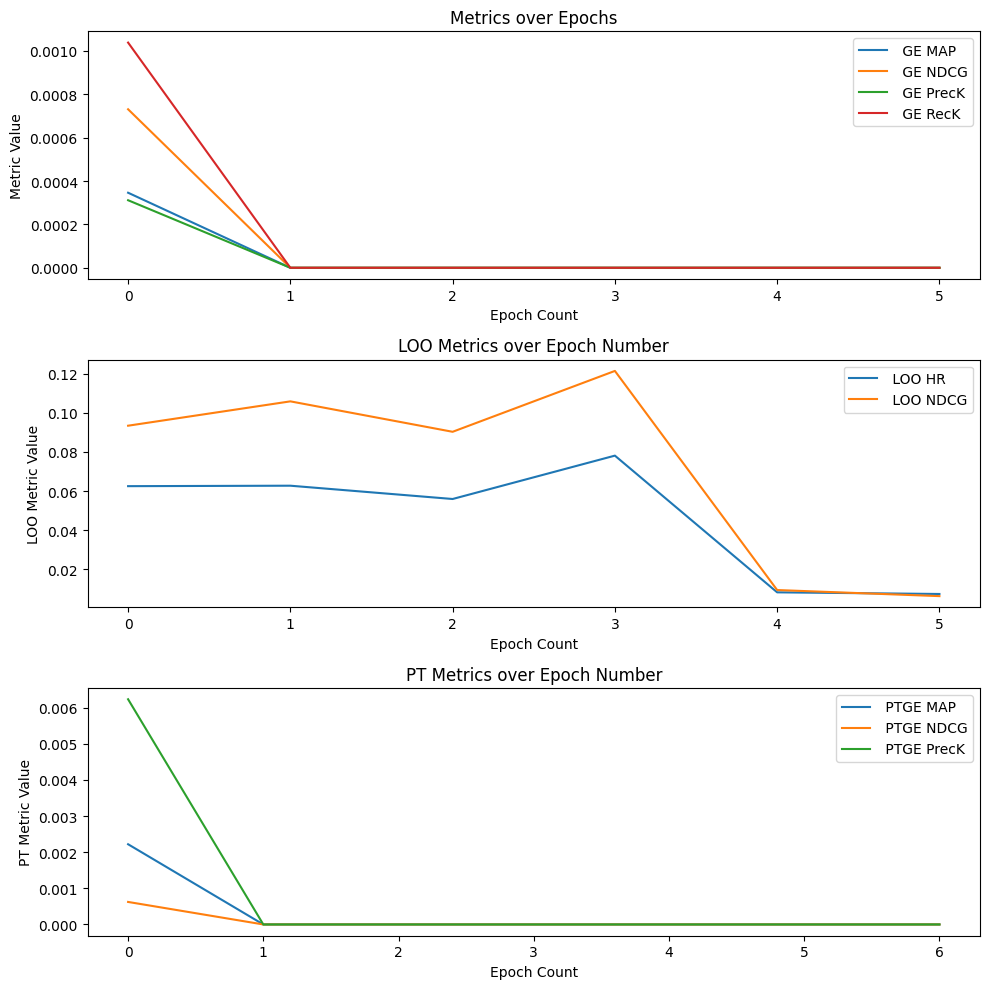

In [191]:
epochs_df = pd.read_csv("epoch_results.csv") 
pt_epochs_df = pd.read_csv("pretrain_epoch_results.csv") 


facts_df_rs = epochs_df.reset_index()

# Set up the plot
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))

# Plot using Seaborn lineplot
sns.lineplot(data=facts_df_rs[[' GE MAP',' GE NDCG',' GE PrecK',' GE RecK']], dashes=False, ax=axes[0])
axes[0].set_title('Metrics over Epochs')
axes[0].set_xlabel('Epoch Count')
axes[0].set_ylabel('Metric Value')
axes[0].legend()

# Plot using Seaborn lineplot
sns.lineplot(data=facts_df_rs[[' LOO HR', ' LOO NDCG']], dashes=False, ax=axes[1])
axes[1].set_title('LOO Metrics over Epoch Number')
axes[1].set_xlabel('Epoch Count')
axes[1].set_ylabel('LOO Metric Value')
axes[1].legend()


pt_facts_df_rs = pt_epochs_df.reset_index()
# Plot using Seaborn lineplot
sns.lineplot(data=pt_epochs_df[[' PTGE MAP', ' PTGE NDCG', ' PTGE PrecK', ' PTGE RecK']], dashes=False, ax=axes[2])
axes[2].set_title('PT Metrics over Epoch Number')
axes[2].set_xlabel('Epoch Count')
axes[2].set_ylabel('PT Metric Value')
axes[2].legend()


# Adjust layout
plt.tight_layout()

# Show plot
plt.show()